In [1]:
import numpy as np
from threeflavorALLvalues import allSigmas
from scipy.integrate import odeint
from solveTmu import blackness
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import brentq, fsolve

from joblib import Parallel, delayed

import matplotlib.pyplot as plt


In [2]:
"Matching Fang paper"
v4=4.2
v3= 0#-1e-6 #-22.6/(6*np.sqrt(2))

def chiral(u,y,params):
    chi,chip=y
    v3,v4,lambda1,mu_g,a0,zh,q=params
    
    Q=q*zh**3
    
    
    "Ballon-Bayona version"
    phi = (mu_g*zh*u)**2-a0*(mu_g*zh*u)**3/(1+(mu_g*zh*u)**4)
    phip = 2*u*(zh*mu_g)**2+a0*(4*u**6*(zh*mu_g)**7/(1+(u*zh*mu_g)**4)**2-3*u**2*(zh*mu_g)**3/(1+(u*zh*mu_g)**4))

    f= 1 - (1+Q**2)*u**4 + Q**2*u**6
    fp= -4*(1+Q**2)*u**3 + 6*Q**2*u**5
    "EOM for chiral field"
    derivs=[chip,
            (3/u-fp/f+phip)*chip - (3*chi+lambda1*phi*chi-3*v3*chi**2-4*v4*chi**3)/(u**2*f)]
            #((3+u**4)/(u-u**5) +phip)*chip - (-3*chi+4*v4*chi**3)/(u**2-u**6) ]
            
    return derivs

def chiral_solve_IR(d0,lambda1,T,mu,ui,uf):
    numpoints=10000
    u=np.linspace(ui,uf,numpoints)
    u_backward=np.linspace(uf,ui,numpoints)


    zeta=np.sqrt(3)/(2*np.pi)

    mu_g=440
    a0=0

    lambda3=v3
    lambda4=v4


    zh,q = blackness(T,mu)
    Q=q*zh**3
    
    #defining constants for Taylor expansion at horizon u=1

    d1 = (3 * d0 - 3 * d0**2 * lambda3 - 4 * d0**3 * lambda4 + d0 * zh**2 * lambda1 * mu_g**2) / (2 * (-2 + Q**2))

    d2 = (1 / (16 * (-2 + Q**2)**2)) * (6 * d1 * (-6 + Q**2 + Q**4) +
    4 * d0**3 * (14 - 13 * Q**2) * lambda4 + d0**2 * ((42 - 39 * Q**2) * lambda3 - 24 * d1 * (-2 + Q**2) * lambda4) -
    2 * d1 * (-2 + Q**2) * zh**2 * (-8 + 4 * Q**2 - lambda1) * mu_g**2 +
    3 * d0 * (-14 + 13 * Q**2 + 8 * d1 * lambda3 - 4 * d1 * Q**2 * lambda3 + (-2 + 3 * Q**2) * zh**2 * lambda1 * mu_g**2))
    

    "IR boundary condition"
    chi0 = d0+d1*(1-uf)+d2*(1-uf)**2
    chip0 = -d1-2*d2*(1-uf)
    y0=[chi0,chip0]




    params=v3,v4,lambda1,mu_g,a0,zh,q
    
    "solve the EOM using solve_ivp"
    sol = solve_ivp(chiral, [uf, ui], y0, t_eval=u_backward, args=(params,))

    #sol=odeint(chiral,y0,u,args=(params,))
    #plot
    chi=sol.y[0][::-1]
    chip=sol.y[1][::-1]
 
    x=zeta*zh*ui
    #first-order approximation
    if v3==0:
        mq1=chi[0]/(zeta*zh*ui)
    else:
        #second-order approximation
       mq1=(x-x*np.sqrt(1-12*v3*chi[0]))/(6*x**2*v3)


    return mq1,chi,chip,u

def sigma_finder(u_intermediate,chi,u,mq,T,mu,zeta,lambda3):
    zh,q = blackness(T,mu)

    "find sigma"
    chi_interp=interp1d(u,chi)
    sigma=(chi_interp(u_intermediate)-mq*zeta*zh*u_intermediate+3*mq**2*zeta**2*lambda3*(zh*u_intermediate)**2)/(u_intermediate*zh)**3*zeta
    return sigma


def chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(chiral_solve_IR)(d0, lambda1, T, mu, ui, uf) for d0 in d0_array
    )
    # Unpack the results
    mq_array, chi_array, chip_array, u_array = zip(*results)
    
    return np.array(mq_array), np.array(chi_array), np.array(chip_array)

In [44]:
#run this to get the initial range of mq vs d0
#mq target should be 50 MeV or some large number
def initial_d0_mq(T,mu,mq_target,lambda1,ui,uf,d0_array):
    
#     d0_array=np.linspace(d0_lower,d0_upper,100)
    mq_array=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)[0]

    max_d0=d0_upper
    # find the indices where abs(mq_array)>150, and remove those indices from d0_array and mq_array
    indices=np.where(np.abs(mq_array)>150)
    # we don't need to go higher than the lowest d0 value that gives garbage results
    # if indices is not an empty array
    if len(indices[0])>0:
        max_d0=d0_array[indices[0]]
    if len(indices[0])>1:
        max_d0=max_d0[0]

    d0_array=np.delete(d0_array,indices)
    mq_array=np.delete(mq_array,indices)
#     mq1_array=np.delete(mq1_array,indices)
    
    iterations=0
    step_size=d0_array[1]-d0_array[0]
    while mq_array[-1]<mq_target and iterations<20:
    #while max(mq_array)<mq_target and iterations<12:

        #create a new d0_array starting above the maximum value of d0_array, with a spacing that is 1/10 of the spacing of the previous d0_array
        step_size=step_size/100
        d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/20,max_d0),step_size)

        # d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),((d0_array[1]-d0_array[0])/100))
        # d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),step_size)
        d0_array=np.concatenate((d0_array,d0_new))
        #calculate the mq_array for the new d0_array
        mq_new=chiral_solve_IR_parallel(d0_new, lambda1, T, mu, ui, uf, n_jobs=-1)[0]
        #add the new mq_array to the old mq_array
        mq_array=np.concatenate((mq_array,mq_new))
#         mq1_array=np.concatenate((mq1_array,mq1_new))

        
        indices=np.where(np.abs(mq_array)>150)
        # we don't need to go higher than the lowest d0 value that gives garbage results
        # if indices is not an empty array
        if len(indices[0])>0:
            max_d0=d0_array[indices[0]]
        if len(indices[0])>1:
            max_d0=max_d0[0]    
        d0_array=np.delete(d0_array,indices)
        mq_array=np.delete(mq_array,indices)
#         mq1_array=np.delete(mq1_array,indices)

        # print(max_d0)
        old_max_d0=max_d0
        iterations=iterations+1
    # print('iterations',iterations)
    return d0_array,mq_array

# finding a range of d0 values that will cover quark masses in a range from 0 to approximately mq_large
T=1
mu=0
mq_large=10
lambda1=6.5
ui=1e-4
uf=1-ui
numpoints=100
d0_lower=80
d0_upper=87.12
d0_array=np.linspace(d0_lower,d0_upper,numpoints)
d0_array, mq_array = initial_d0_mq(T, mu, mq_large, lambda1, ui, uf, d0_array)

d0_old=d0_array
d0_min=d0_array[np.abs(mq_array)>1e-3][0]
mq_array=mq_array[d0_array>d0_min]
d0_array=d0_array[d0_array>d0_min]
# it seems that the first two points are identical, so remove one
d0_array=d0_array[1:]
mq_array=mq_array[1:]
"This works, but makes WAY too many points"
# smallest_diff=np.min(np.gradient(d0_array))

# d0_array=np.arange(d0_array[0],d0_array[-1]+smallest_diff,smallest_diff)

# d0_array, mq_array = initial_d0_mq(T, mu, mq_large, lambda1, ui, uf, d0_array)

# solving from IR again to retain the function chi and its derivative chip for each value of d0
_,chis,chips=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)

#picking the value of u_int. There are 1000 points in u, so i ~ 1000*u_int
i=10
u=np.linspace(ui,uf,len(chips[0]))
u_int=u[i]
chi0=chis[:,i]
chip0=chips[:,i]

#solving for mq and sigma
lambda3=v3
zeta=np.sqrt(3)/(2*np.pi)
zh,q=blackness(T,mu)
# if lambda3 is nonzero, calculate mq and sigma using the improved formula
# if lambda3 is zero, calculate mq and sigma using the round formula
if lambda3==0:
    sigma_improved=zeta*(chip0*u_int-chi0)/(2*u_int**3*zh**3)
    mq_improved=mq_array#chi0/(zeta*zh*u_int)
else:
    mq_improved=(1-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*lambda3*zeta*u_int*zh)
    sigma_improved=zeta*(1-6*chi0*lambda3+3*chip0*u_int*lambda3-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*u_int**3*zh**3*lambda3)



/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_5449/3018266031.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


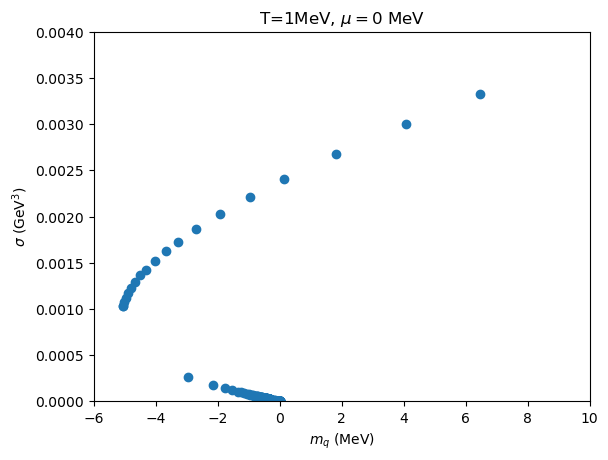

In [4]:
plt.scatter(mq_improved,sigma_improved/1e9)#,label="$u_{int}= $"+str(round(u[i]*1000)/1000))
# plt.plot(mq_array_1,sigma_1/1e9)
plt.xlabel("$m_q$ (MeV)")
plt.ylabel("$\sigma$ (GeV$^3$)")
plt.xlim(-6,10)
plt.ylim(0,0.004)
plt.title("T="+str(T)+"MeV, $\mu=$"+str(mu)+" MeV")
plt.show()

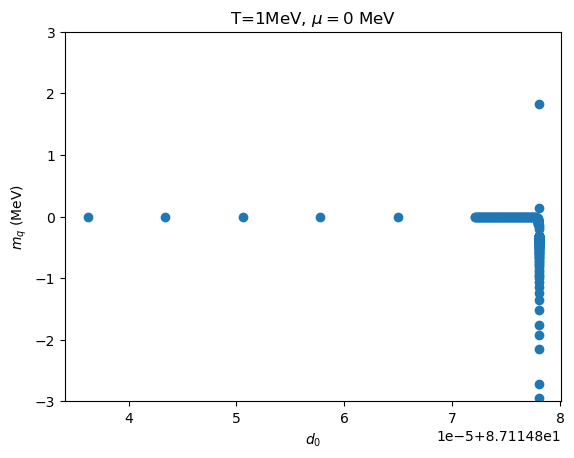

In [10]:
plt.scatter(d0_array,mq_improved)  
plt.xlabel("$d_0$")
plt.ylabel("$m_q$ (MeV)")
plt.title("T="+str(T)+"MeV, $\mu=$"+str(mu)+" MeV")
plt.ylim(-3,3)
plt.show()

In [34]:
# create an array of quark mass values from the minimum of mq_array to 20 with 100 points
mq_array=np.linspace(np.min(mq_improved),20,1000)


In [67]:
mq_target=-2

#find the indices where mq_array-mq_target changes sign
indices=np.where(np.diff(np.sign(mq_improved-mq_target)))[0]
# loop over the indices
for index in indices:
    #create an array consisting of mq_improved[index] and mq_improved[index+1]
    mq_approx=np.array([mq_improved[index],mq_improved[index+1]])
    #create an array of d0 values consisting of d0_array[index] and d0_array[index+1]
    d0_approx=np.array([d0_array[index],d0_array[index+1]])
    #create an interpolation function for d0_approx vs mq_approx
    d0_interp=interp1d(mq_approx,d0_approx)
    #find the d0 value that corresponds to mq_target
    d0=d0_interp(mq_target)
    #solve for chi and chip using the EOM
    mq,chi,chip,u=chiral_solve_IR(d0,lambda1,T,mu,ui,uf)
    print(mq)
    #picking the value of u_int. There are 1000 points in u, so i ~ 1000*u_int
    i=10
    u=np.linspace(ui,uf,len(chip))
    u_int=u[i]
    chi0=chi[i]
    chip0=chip[i]

    #solving for mq and sigma
    lambda3=v3
    zeta=np.sqrt(3)/(2*np.pi)
    zh,q=blackness(T,mu)
    # if lambda3 is nonzero, calculate mq and sigma using the improved formula
    # if lambda3 is zero, calculate mq and sigma using the round formula
    if lambda3==0:
        sigma_improved=zeta*(chip0*u_int-chi0)/(2*u_int**3*zh**3)
        mq_improved=chi0/(zeta*zh*u_int)
    else:
        mq_improved=(1-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*lambda3*zeta*u_int*zh)
        sigma_improved=zeta*(1-6*chi0*lambda3+3*chip0*u_int*lambda3-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*u_int**3*zh**3*lambda3)
    print("d0=",d0)
    print("mq=",mq_improved)
    print("sigma=",sigma_improved)

ValueError: diff requires input that is at least one dimensional

In [63]:
chi[i]

0.00012359795971807267

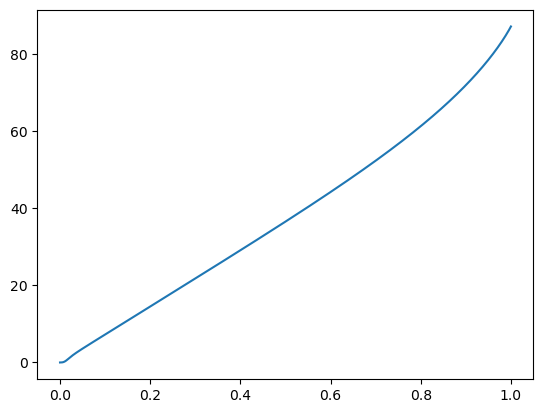

In [60]:
plt.plot(u,chi)
plt.show()

In [52]:
#create an array of with 18 elements starting at 12 and incrementing by 0.5


In [31]:
print(mq_improved[199:217])

[-1.52215958 -1.76098129 -2.15199199 -2.95002342 -5.05469913 -5.05469913
 -5.01348492 -4.95901815 -4.8818237  -4.78985231 -4.65845983 -4.48899921
 -4.31845948 -4.02799046 -3.66645419 -3.27091559 -2.71185668 -1.92384053]


In [37]:
#create an interpolating function for mq_improved vs d0_array
mq_interp=interp1d(d0_array,mq_improved)

mq_interp(d0_change)

array([-1.76098129, -2.71185668])

In [47]:
d0_interp=interp1d(mq_improved,d0_array)
d0_interp(2)

array(87.11487801)